# 0.0 Configurações Básicas


In [ ]:
#Permissão para acessar algum arquivo do Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [2]:
#aumentado a capacidade de visualização de colunas e linhas
import pandas as pd

pd.set_option('display.max_columns', 7000)
pd.set_option('display.max_rows',90000)

# 1.0 Introdução

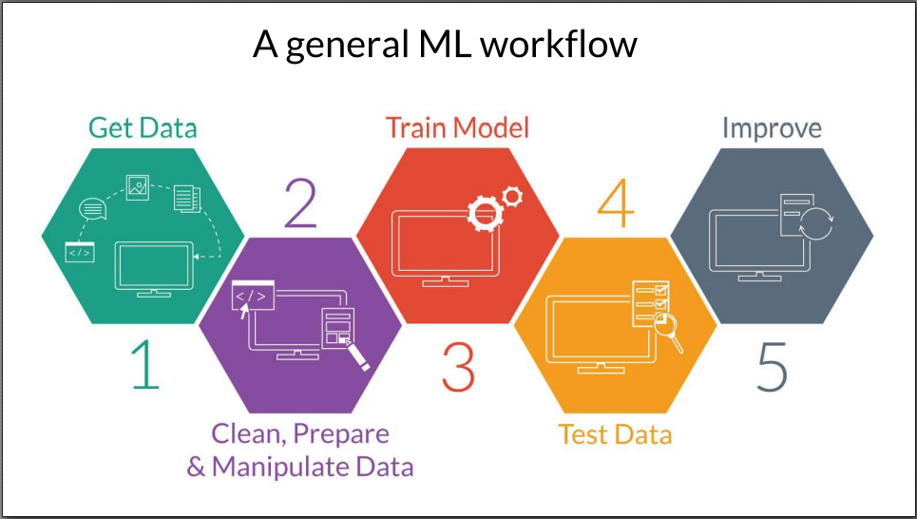

Nesta prática, vamos realizar todas as etapas ilustradas acima.
* Get the Data
  * Carregue a base de dados
  * Analise a sua estrutura
* Prepare the Data
  * Identificação de registros duplicados
  * Seleção dos atributos
  * Limpeza dos atributos
  * Tratamento e transformação dos atributos não numéricos  
  * Normalização dos atributos
* Train Model & Test Data
  * Treine, teste e avalie o modelo inicial
* Improve the Model
  * Ajuste o seu modelo, treine e teste
* Save the model
  * salva o modelo e coloca em produção
  




#2.0 Get the data


Embora o Airbnb não divulgue dados sobre os seus anúncios, um grupo separado chamado [Inside Airbnb](https://insideairbnb.com/get-the-data/) extraiu informações de uma amostra de anúncios de muitas das principais cidades do site.

Nesta aula, trabalharemos com o conjunto de dados deles de 19 de junho de 2020 sobre os anúncios do Rio de Janeiro.Cada linha do conjunto de dados é um anúncio específico disponível para aluguel no Airbnb no Rio de Janeiro.

Um desafio que os locadores (hosts) que desejam alugar seu espaço residencial enfrentam é determinar o preço ideal do aluguel por noite.

Vamos usar os dados de anúncios locais para prever **o preço ótimo que devemos definir**. Será explorado a técnica supervisionada de aprendizagem de máquina chamada [k-nearest neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) (k-vizinhos mais próximos). Ela será utilizada para sugerir um preço para um novo anúncio sem preço. Usaremos, neste projeto, um valor k de 5.

Agora, vamos nos familiarizar com o conjunto de dados com o qual trabalharemos.

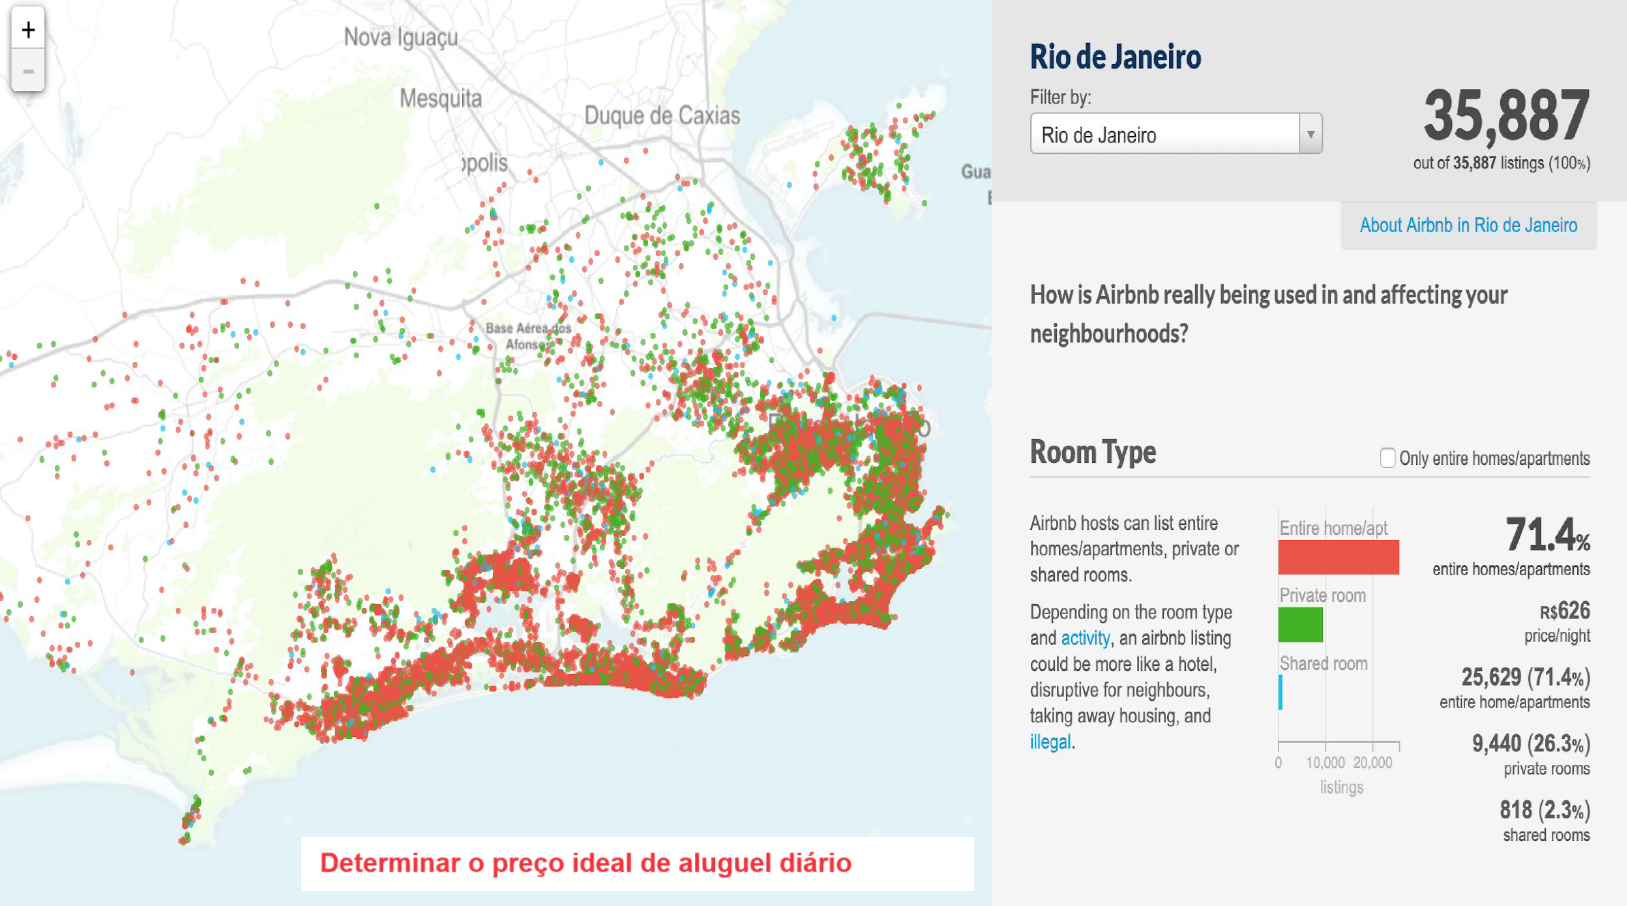

Para tornar o conjunto de dados mais fácil de trabalhar, removeremos muitas das colunas do conjunto de dados original (106 colunas). Aqui estão as colunas que manteremos:
- **host_response_rate**: taxa de resposta do anfitrião
- **host_acceptance_rate**: número de solicitações ao anfitrião que se converteram em locações
-**host_listings_count**: número de outros anúncios do anfitrião
- **latitude**: latitude da coordenada geográfica
- **longitude**: longitude da coordenada geográfica
- **city**: cidade onde o espaço está localizado
- **zipcode**: o cep onde o espaço está localizado
- **state**: o estado onde o espaço está localizado
- **accommodates**: capacidade máxima de hóspedes
- **room_type**: tipo de acomodação (valores: Private room, Shared room or Entire home/apt)
- **bedrooms**: número de quartos
- **bathrooms**: número de banheiros
- **beds**: número de camas
- **price**: preço da diária
- **cleaning_fee**: taxa de limpeza
- **security_deposit**: depósito de segurança reembolsável, em caso de danos
- **minimum_nights**: estadia mínima
- **maximum_nights**: estadia máxima
- **number_of_reviews**: número de avaliações de hóspedes anteriores

##2.1 Carrega a base de dados

In [3]:
import pandas as pd
# read the dataset to a Pandas' dataframe
data = pd.read_csv("drive/My Drive/CursoParadigmasdeAprendizagemMaquina/Pratica3/listings.csv",low_memory=False)

##2.2 Verificando a estrutura dos dados

In [ ]:
data.head()

O método **info()** é útil para obter uma descrição rápida dos dados, em particular o número total de linhas e o tipo e número de valores não nulos de cada atributo.

In [ ]:
data.info(max_cols=110)

In [ ]:
import pandas as pd
target_columns = ["host_response_rate", "host_acceptance_rate", "host_listings_count",
                  "latitude","longitude","city","zipcode","state","accommodates",
                  "room_type","bedrooms","bathrooms","beds","price","cleaning_fee",
                  "security_deposit","minimum_nights","maximum_nights","number_of_reviews"]

rio_listings = data[target_columns].copy()
rio_listings.head()

In [ ]:
rio_listings.info()

In [ ]:
# Você pode descobrir quais categorias existem e
# quantos espaços pertencem a cada categoria
# utilizando o comando value_counts()

rio_listings.room_type.value_counts()

##2.3 Realizando uma análise de dados rápida  utilizando o Pandas *Profiling* (*ydata-profiling*)

O Pandas [Profiling](https://pypi.org/project/pandas-profiling/)  simplifica o processo de obter uma visão geral da base de dados, gerando um relatório abrangente do seu conjunto de dados, minimizando o tempo para explorar esses grandes conjuntos de dados.

In [10]:
pip install ydata-profiling

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.2/356.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 37.0 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=b0282ac7068ddc7feabdeb7b083b0c6e2487478a3772e605319b94947d1134c1
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin


In [11]:
import  ydata_profiling
from ydata_profiling import ProfileReport

profile = ProfileReport(rio_listings)
profile.to_notebook_iframe()

Output hidden; open in https://colab.research.google.com to view.

#3.0 K-nearest neighbors

A estratégia que iremos usar:
- Encontrar anúncios similares.
- Calcular o preço médio de aluguel diário desses anúncios.
- Definir o preço médio como o preço do nosso anúncio.

Existem duas coisas que precisamos definir:
- A métrica de similaridade
- Como escolher o valor de k
Vamos explorar esses pontos para entender melhor como implementar nossa estratégia.

##3.1 Distância Euclidiana


A métrica de similaridade funciona comparando um conjunto de atributos.Quando se tenta prever um valor contínuo, como o preço, a principal métrica de similaridade usada é a **Distância Euclidiana**.

Como estamos usando apenas uma característica (atributo), isso é conhecido como caso univariado. Aqui está a fórmula para o caso univariado:

$\displaystyle d = \sqrt{(q_1 - p_1)^2}$

A raiz quadrada e a potência quadrada se cancelam e a fórmula simplifica para:

$ \displaystyle d = \left | q_1 - p_1 \right |$

Onde $q_1$ representa o valor do atributo para uma observação (instância) e $p_1$ representa o valor do atributo para  outra observação (instância).

O espaço que queremos alugar acomoda 3 pessoas. Vamos primeiro calcular a distância, usando apenas o atributo **accommodates**, da primeira instância do conjunto de dados e o nosso.


**Exercício**

1. Calcule a distância euclidiana entre nosso espaço, que pode acomodar 3 pessoas, e o primeiro espaço no DataFrame **rio_listings**. Utilize apenas a coluna **accommodates**.
2. Atribua o resultado a **first_distance** e exiba o valor usando a função **print**.

In [ ]:
# put your code here

A distância euclidiana entre a primeira linha do DataFrame rio_listings e nosso próprio espaço é 2. Como sabemos se isso é alto ou baixo?

Se você olhar para a própria equação da distância euclidiana, o menor valor que pode ser alcançado é 0. Isso acontece quando o valor do atributo é exatamente o mesmo para ambas as instâncias que você está comparando. Quanto mais próximo de **0** for a distância, mais similares são os espaços dos anúncios.

**Exercício**

1. Calcule a distância entre cada valor na coluna **accommodates** do DataFrame **rio_listings2** e o valor 3, que é o número de pessoas que nosso anúncio acomoda:
    - Use o método [apply](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.apply.html) para calcular o valor absoluto da diferença entre cada valor na coluna "accommodates" e o número 3 e retornar uma nova Série contendo os valores de distância.
2. Atribua os valores de distância à coluna **distance**.
3. Use o método **value_counts** e a função **print** para exibir a contagem dos valores únicos na coluna **distance**.

In [ ]:
# put your code here

Parece que existem muitos, precisamente **3679** espaços que podem acomodar, exatamente, 3 pessoas como o nosso. Isso significa que os 5 "vizinhos mais próximos" que selecionarmos após classificar todos terão um valor de distância de **0**.

In [ ]:
target_accommodates = 3

rio_listings2["distance"] = rio_listings2["accommodates"].apply(lambda x: abs(x - target_accommodates))
print(rio_listings2["distance"].value_counts())

In [ ]:
rio_listings2[rio_listings2["distance"] == 0]["accommodates"]

#4.0 Prepare the data

##4.1 Verificação da ocorrência de dados duplicados

Com a base de dados completa, só devemos tirar os duplicados. Para verificar a ocorrência de instâncias duplicadas, utilizaremos o método [duplicated()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html).

In [ ]:
#Identifica registros duplicados nos dados
dupes=rio_listings.duplicated()
sum(dupes)

Caso, exista linhas duplicadas em nossa base de dados, devemos retirar, utilizando o método [drop_duplicates()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html).

In [13]:
#remoção dos duplicados
rio_listings_ok = rio_listings.drop_duplicates(keep='first')

In [ ]:
#Identifica registros duplicados nos dados
dupes=rio_listings_ok.duplicated()
sum(dupes)

## 4.2 Remoção de atributos

As seguintes colunas contêm valores não-numéricos:

- **room_type**: por exemplo, **Private room**
- **city**: por exemplo, **Rio de Janeiro**
- **state**: por exemplo, **RJ**

enquanto essas colunas contêm valores numéricos, mas não ordinais:

- **latitude**: por exemplo, **-22.92**
- **longitude**: por exemplo, **-43.23**
- **zipcode**: por exemplo, **20550-012**

Valores geográficos como esses não são ordinais, pois um valor numérico menor não corresponde diretamente a um valor menor de forma significativa. Por exemplo, o código postal 20009 não é menor ou maior que o código postal 75023 e, em vez disso, ambos são valores identificadores únicos. Os pares de valores de latitude e longitude descrevem um ponto em um sistema de coordenadas geográficas.

Embora pudéssemos converter as colunas "host_response_rate" e "host_acceptance_rate" para numéricas (no momento, elas são tipos de dados de objeto e contêm o sinal "%"), essas colunas descrevem o host e não o próprio espaço a ser alugado. Como um host pode ter muitos espaços  e não temos informações suficientes para agrupar exclusivamente os espaços  aos próprios hosts, vamos evitar usar qualquer coluna que não descreva diretamente o espaço:

- **host_response_rate**
- **host_acceptance_rate**
- **host_listings_count**

Vamos remover essas 9 colunas do Dataframe

**Exercício**

1. Remove as 9 columns discutidas acima de **rio_listings_ok**:
  
2. Verifique o número de valores nulos existentes em cada coluna restante.


In [ ]:
# put your code here

##4.3 Tratamento dos dados faltantes


Das colunas restantes, 3 colunas têm alguns valores ausentes (menos de 1% do número total de linhas):
- **bedrooms**
- **bathrooms**
- **beds**

Como o número de linhas contendo valores ausentes para uma dessas 3 colunas é baixo, podemos selecionar e remover essas linhas sem perder muita informação. Existem também 2 colunas com um grande número de valores ausentes:

- **cleaning_fee** - 34.55% do total de linhas
- **security_deposit** - 45.83% do total de linhas

Não podemos, simplesmente, remover as linhas que contêm valores ausentes nessas 2 colunas, porque perderíamos a maioria das observações no conjunto de dados. Em vez disso, vamos remover essas 2 colunas completamente da bade de dados.

**Exercício**

1. Remova as colunas **cleaning_fee** and **security_deposit** de **rio_listings_ok**.
2. Remova todas as linhas que contêm valores faltantes nas colunas: **bedrooms**, **bathrooms** e **beds** de **rio_listings_ok**.
    - Dica: utilize o método [dropna()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.dropna.html).
3. Exiba a quantidade de valores NaN por coluna para o dataframe **rio_listings_ok** para confirmar que não existe mais nenhum valor faltante.

In [ ]:
# put your code here

##4.4 Tratamento e transformação dos dados não numéricos

In [ ]:
rio_listings_ok.head()

In [22]:
# Data preparation
stripped_commas = rio_listings_ok['price'].str.replace(',', '')
stripped_dollars = stripped_commas.str.replace('$', '')
rio_listings_ok['price'] = stripped_dollars.astype('float')

In [ ]:
rio_listings_ok.head()

In [ ]:
rio_listings_ok.info()

##4.5 Procurando por correlações entre os atributos


Vamos analisar a correlação dos atributos com o atributo alvo

In [ ]:
# Identify feature with a high correlation to target
rio_listings_ok.corr()["price"].sort_values()

<Axes: >

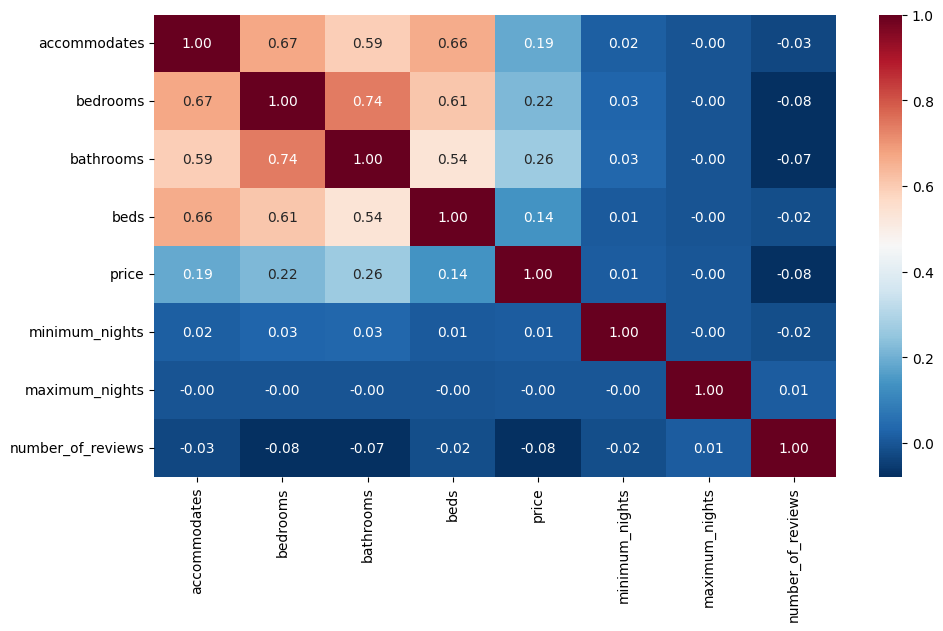

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(11, 6))
sns.heatmap(rio_listings_ok.corr(),
            annot=True,
            fmt=".2f",
            cmap="RdBu_r",)

Esta rodada de exploração não precisa ser absolutamente completa. O objetivo é  obter rapidamente insights que o ajudarão a obter um primeiro protótipo razoavelmente bom. Mas este é um **processo iterativo**: depois de ter um protótipo funcionando, você pode analisar sua saída para obter mais insights e voltar a esta etapa de exploração.

##4.6 Criação dos conjuntos de treinamento e teste


Antes de retirar os outliers e normalizar os valores dos atributos, iremos dividir a base de dados em treinamento e teste para garantir que não ocorra vazamento de dados

In [28]:
from sklearn.model_selection import train_test_split
test_size = 0.20
seed = 10

train_set, test_set = train_test_split(rio_listings_ok,
                                       test_size=test_size,
                                       random_state=seed)

In [ ]:
print("train_set: {}".format(train_set.shape))
print("test_set: {}".format(test_set.shape))

##4.7 Remoção dos Outliers

É importante ressaltar que a decisão de considerar um valor como outlier depende do contexto do problema e do domínio do assunto. Portanto, é necessário analisar cuidadosamente cada ponto destacado e avaliar se eles são verdadeiros outliers ou apenas valores extremos válidos.

Vamos utilizar para remover os outliers o Intervalo Interquartil (IQR).  IQR é uma medida estatística robusta que nos ajuda a quantificar a dispersão dos dados e identificar valores discrepantes (outliers).

O IQR pode ser calculado para determinar os limites de aceitação de valores dentro de um conjunto de dados.

 É comum utilizar uma regra prática que considera valores como outliers se estiverem além de um determinado limite, definido como Q1–1,5 * IQR para os valores inferiores e Q3 + 1,5 * IQR para os valores superiores. Pontos fora desses limites são destacados como possíveis outliers.


###4.7.1 Retirando os outliers da base de treinamento


Vamos analisar a ocorrência de outliers, utilizando a função describe do Pandas

In [ ]:
train_set.describe()

Vamos identificar outliers utilizando o boxplot

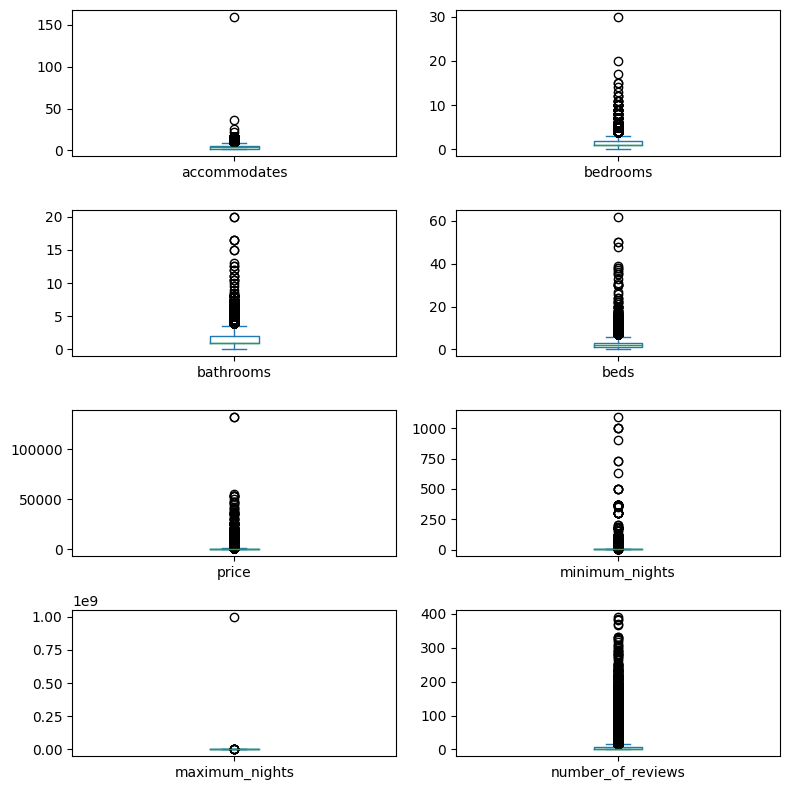

In [31]:
import matplotlib.pyplot as plt
train_set[train_set.columns].plot(kind='box',
                        layout=(4,2),
                        subplots=True,
                        figsize=(8,8),
                        sharex=False)
plt.tight_layout()
plt.show()

In [32]:
# copy the dataset
rio = train_set.copy()

# 25th Quartile
Q1 = train_set.quantile(0.25)

# 75th Quartile
Q3 = train_set.quantile(0.75)

# Inter-quartile range
IQR = Q3 - Q1

# lower limit
low = Q1 - 1.5 * IQR

# upper limit
up = Q3 + 1.5 * IQR

# remove outliers
train_set = train_set[((train_set > low).all(axis=1) & (train_set < up).all(axis=1))]

In [ ]:
print(f"Before: {rio.shape[0]} rows\nAfter: {train_set.shape[0]} rows")
print("Reduction of {:.2f} %".format((1-train_set.shape[0]/rio.shape[0])*100))

In [ ]:
# Identify feature with a high correlation to target
train_set.corr()["price"].sort_values()

<Axes: >

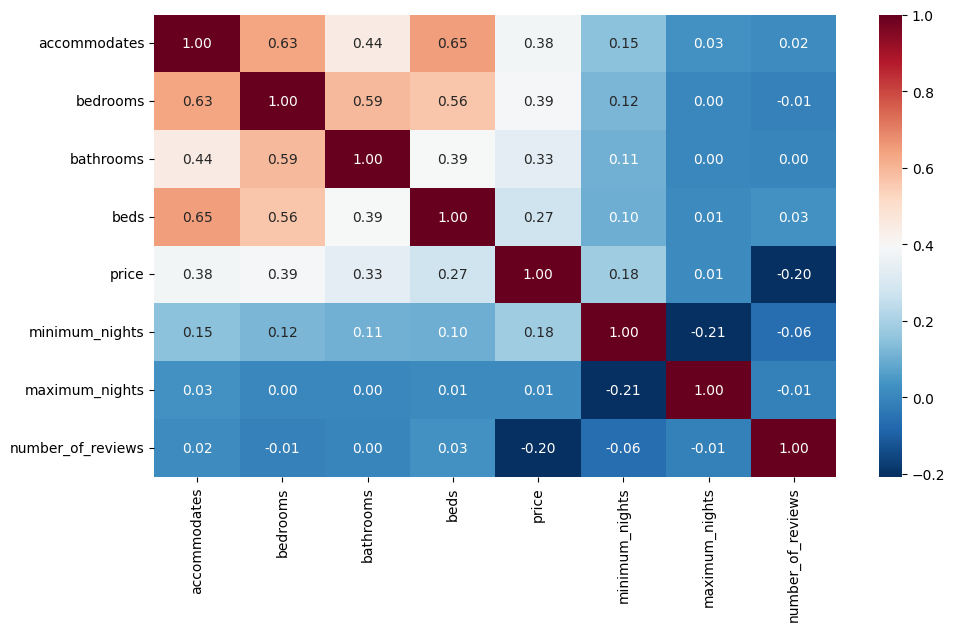

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(11, 6))
sns.heatmap(train_set.corr(),
            annot=True,
            fmt=".2f",
            cmap="RdBu_r",)

In [ ]:
train_set.describe()

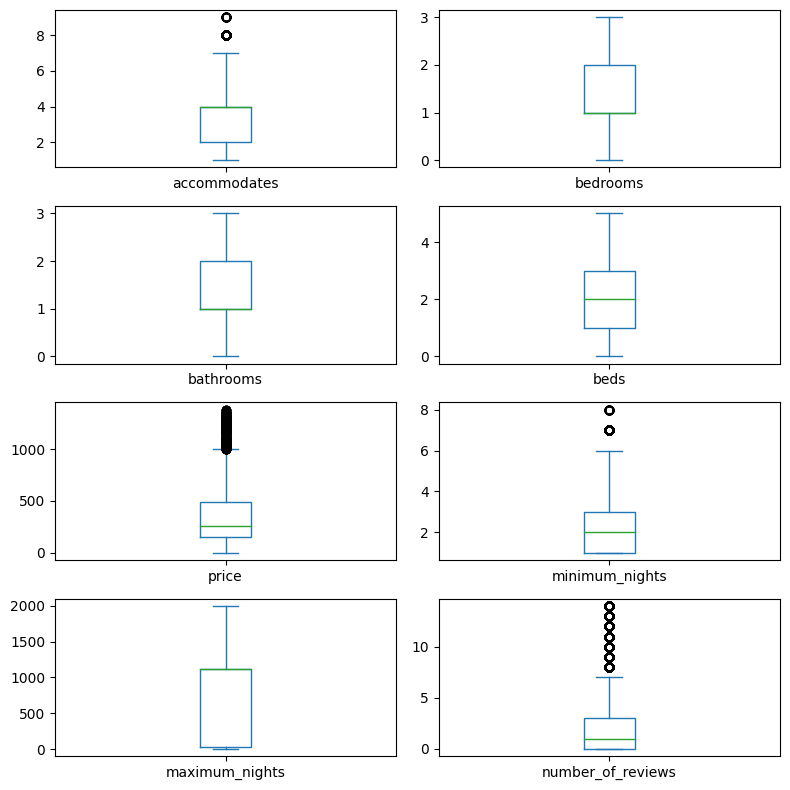

In [37]:
train_set.plot(kind='box',layout=(4,2),
                        subplots=True,
                        figsize=(8,8),
                        sharex=False)

plt.tight_layout()
plt.show()

###4.7.2 Retirando os outliers da base de teste


Vamos analisar a ocorrência de outliers, utilizando a função describe do Pandas

In [ ]:
test_set.describe()

Vamos identificar outliers utilizando o boxplot

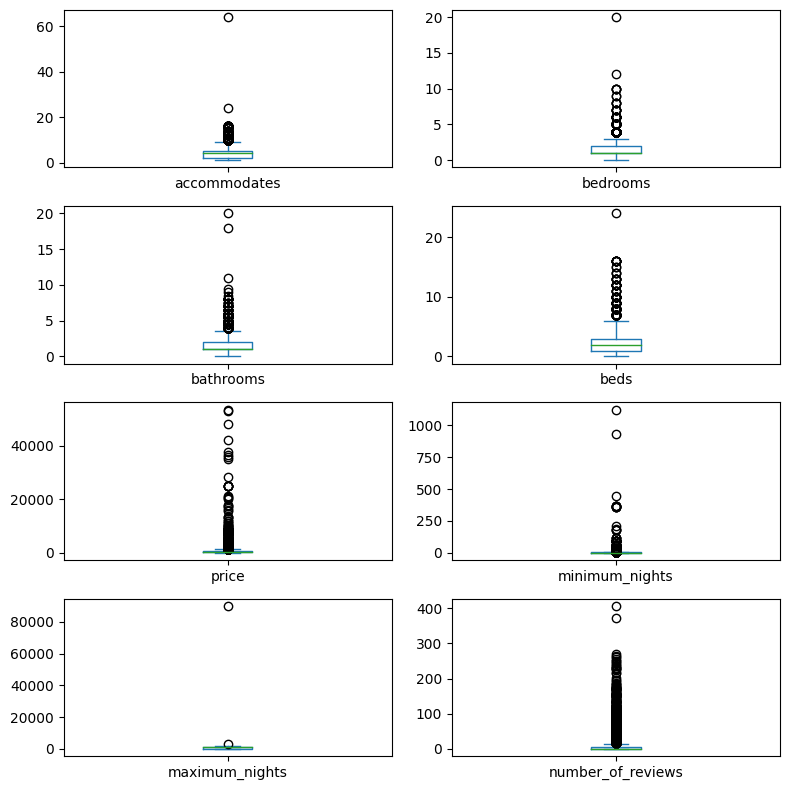

In [39]:
import matplotlib.pyplot as plt
test_set[test_set.columns].plot(kind='box',
                        layout=(4,2),
                        subplots=True,
                        figsize=(8,8),
                        sharex=False)
plt.tight_layout()
plt.show()

In [40]:
# copy the dataset
rio_test = test_set.copy()

# 25th Quartile
Q1 = test_set.quantile(0.25)

# 75th Quartile
Q3 = test_set.quantile(0.75)

# Inter-quartile range
IQR = Q3 - Q1

# lower limit
low = Q1 - 1.5 * IQR

# upper limit
up = Q3 + 1.5 * IQR

# remove outliers
test_set = test_set[((test_set > low).all(axis=1) & (test_set < up).all(axis=1))]

In [ ]:
print(f"Before: {rio_test.shape[0]} rows\nAfter: {test_set.shape[0]} rows")
print("Reduction of {:.2f} %".format((1-test_set.shape[0]/rio_test.shape[0])*100))

In [ ]:
# Identify feature with a high correlation to target
test_set.corr()["price"].sort_values()

<Axes: >

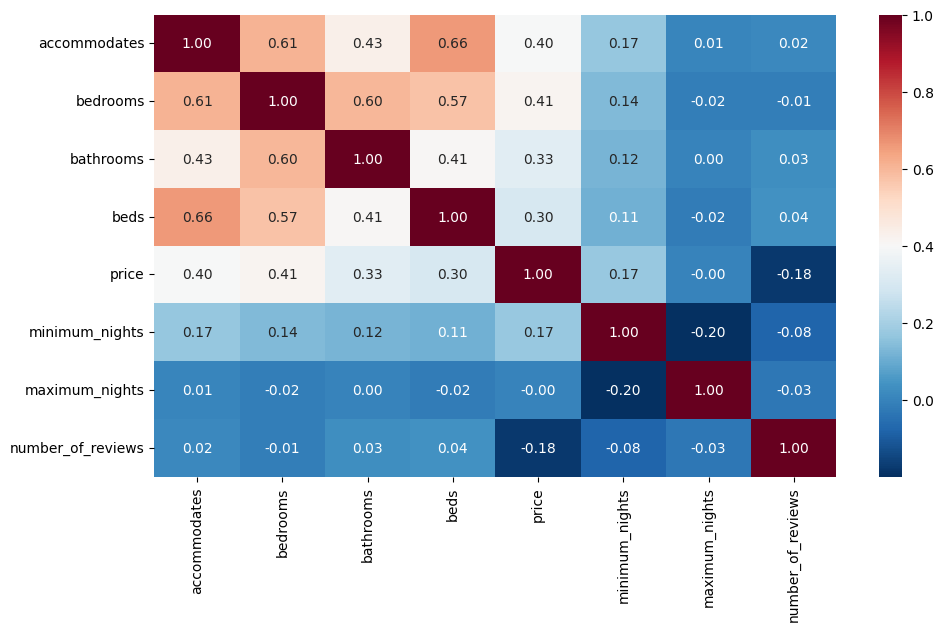

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(11, 6))
sns.heatmap(test_set.corr(),
            annot=True,
            fmt=".2f",
            cmap="RdBu_r",)

In [ ]:
test_set.describe()

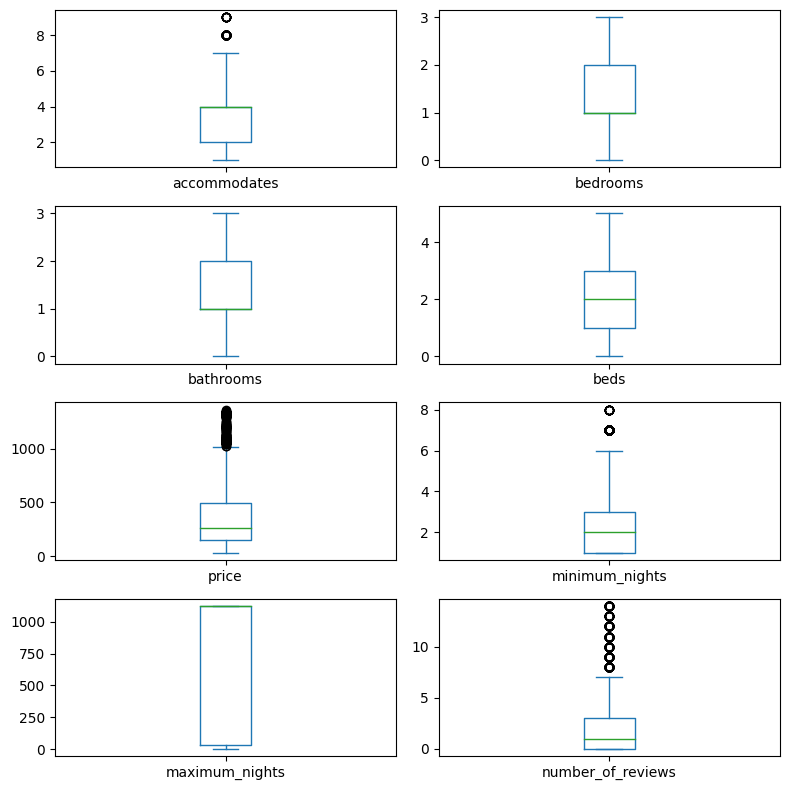

In [45]:
test_set.plot(kind='box',layout=(4,2),
                        subplots=True,
                        figsize=(8,8),
                        sharex=False)

plt.tight_layout()
plt.show()

##4.8 Escalonamento dos atributos

Uma das transformações mais importantes que você precisa aplicar aos seus dados é o escalonamento de atributos. Com poucas exceções, os algoritmos de Machine Learning não funcionam bem quando os atributos numéricos de entrada têm escalas muito diferentes.

**Geralmente não é necessário escalonar os valores alvo (target), pois a maioria dos algoritmos de aprendizado de máquina se concentra em minimizar o erro entre as previsões e os valores reais da variável alvo, e não na escala dos valores em si.**

Existem várias maneiras de fazer com que todos os atributos tenham a mesma escala:
- Escalonamento min-max (Normalização)
- Padronização
- RobustScaler
- PowerTransformer

O **escalonamento Min-Max** é bem simples: os valores são deslocados e reescalados para que acabem variando de 0 a 1. Isso é feito  subtraindo o valor mínimo e dividindo pelo máximo menos o mínimo.Scikit-Learn fornece um transformador para isso chamado [MinMaxScaler()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html). MinMaxScaler não reduz a importância dos outliers.MinMaxScaler não é um mau ponto de partida, a menos que você queira que seus atributos tenham uma distribuição normal ou tenha outliers e queira que eles tenham influência reduzida.

A **padronização** é bem diferente: primeiro, ela subtrai o valor médio (então os valores padronizados sempre têm uma média zero) e, em seguida, divide pela variância para que a distribuição resultante tenha variância unitária. Variância unitária significa dividir todos os valores pelo desvio padrão. Scikit-Learn fornece um transformador para padronização:  [StandardScaler()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). StandardScaler torna a média da distribuição aproximadamente 0.

Ao contrário do escalonamento Min-Max, a padronização não limita os valores a um intervalo específico e a padronização é muito menos afetada por **outliers**. Algoritmos de aprendizagem profunda frequentemente exigem média zero e variância unitária. Algoritmos do tipo regressão também se beneficiam de dados normalmente distribuídos com pequenos tamanhos de amostra.

[RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html) transforma o vetor de atributos subtraindo a mediana e, em seguida, dividindo pelo intervalo interquartil (valor de 75% menos o valor de 25%).Assim como o MinMaxScaler, nossos atributos com valores grandes, após a trnaformação, estão em uma escala similar aos outros atributos. Observe que o RobustScaler não escala os dados em um intervalo predeterminado como o MinMaxScaler. Utilize RobustScaler se deseja reduzir os efeitos de outliers em comparação com MinMaxScaler.

O [PowerTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html) é uma ferramenta poderosa no scikit-learn que permite transformar seus dados de forma a se aproximarem mais de uma distribuição normal (ou gaussiana). Essa transformação é especialmente útil quando seus modelos de machine learning assumem que os dados seguem uma distribuição normal, como muitos modelos lineares. O PowerTransformer aplica uma família de transformações paramétricas monótonas aos seus dados. As transformações mais comuns são a Box-Cox e a Yeo-Johnson. Essas transformações estimam um parâmetro ótimo para estabilizar a variância e minimizar a assimetria dos dados.

Primeiro vamos separar os atributos preditores (X) do atributo alvo(Y)

In [46]:
# Para lembrar como dividimos nossa base
# train_set, test_set = train_test_split(data, test_size=0.20, random_state=10)

# drop retira da base de treinamento a coluna alvo
train_X = train_set.drop("price", axis=1)

# cria o conjunto y (conjunto de rótulos)
train_y = train_set.price.copy()

# drop retira da base de teste a coluna alvo
test_X = test_set.drop("price", axis=1)

# cria o conjunto y (conjunto de rótulos)
test_y = test_set.price.copy()

In [ ]:
print(f"Train x: {train_X.shape}\nTrain y: {train_y.shape}")
print(f"Test x: {test_X.shape}\nTest y: {test_y.shape}")

In [ ]:
train_X.describe()

In [49]:
test_X.describe()

,accommodates,bedrooms,bathrooms,beds,minimum_nights,maximum_nights,number_of_reviews
count,4449.000000,4449.000000,4449.000000,4449.000000,4449.000000,4449.000000,4449.000000
mean,3.527534,1.380310,1.420432,2.014835,2.697235,648.258036,2.367723
std,1.630068,0.729719,0.600291,1.128743,1.681013,535.717665,3.308426
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,1.000000,30.000000,0.000000
50%,4.000000,1.000000,1.000000,2.000000,2.000000,1125.000000,1.000000
75%,4.000000,2.000000,2.000000,3.000000,3.000000,1125.000000,3.000000
max,9.000000,3.000000,3.000000,5.000000,8.000000,1125.000000,14.000000


In [52]:
# Vamos escalonar usando PowerTransformer
from sklearn.preprocessing import PowerTransformer

# Instantiate a normalization algorithm
pt = PowerTransformer()
# Learning the stats from feature
pt.fit(train_X)
# Transform x train
scaler_train = pt.transform(train_X)
# Transform x test
scaler_test = pt.transform(test_X)

In [54]:
#Convertendo os arrays para um dataframe
train_X_df = pd.DataFrame(scaler_train, columns=train_X.columns)
test_X_df = pd.DataFrame(scaler_test, columns=test_X.columns)

In [ ]:
train_X_df.describe()

In [ ]:
test_X_df.describe()

#5.0 Train Model & Test Data (create a baseline model)

In [70]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
# Treinamento

# instancie um knn object
knn = KNeighborsRegressor(n_neighbors=5, n_jobs=-1)

# train the model
%time knn.fit(train_X_df,train_y)

In [ ]:
# predict
%time predict = knn.predict(test_X_df)

O RMSE (Root Mean Squared Error) é uma métrica utilizada para avaliar o desempenho de modelos de regressão. Ele representa a raiz quadrada da média dos erros quadráticos entre os valores preditos pelo modelo e os valores reais.

In [ ]:
# avalie o modelo
rmse = np.sqrt(mean_squared_error(test_y,predict))
print(rmse)

#6.0 Otimização dos hiperparâmetros

Quando variamos os atributos utilizados no modelo, estamos afetando os dados que o modelo usa. Por outro lado, variar os K valores dos parâmetros do algoritmo de aprendizagem de máquina afeta o comportamento do modelo independentemente dos dados reais utilizados na hora de fazer previsões. Em outras palavras, estamos impactando o desempenho do modelo sem tentar mudar os dados utilizados.

Valores que afetam o comportamento e desempenho de um modelo que são não relacionados aos dados utilizados são referidos como **hiperparâmetro**. O processo de encontrar o valor ótimo do hiperparâmetro é conhecido como **otimização do hiperparâmetro**. Uma técnica comum é conhecida como [grid search](https://en.wikipedia.org/wiki/Hyperparameter_optimization#Grid_search), que envolve:

- selecionar um subconjunto dos possíveis valores de hiperparâmetro,
- treinar um modelo usando cada um desses valores de hiperparâmetro,
- avaliar o desempenho de cada modelo,
- selecionar o valor do hiperparâmetro que resultou no menor valor de erro.

Essencialmente, Grid search se resume a avaliar o desempenho do modelo em diferentes valores de k e selecionar o valor de k que resultou no menor erro. Um ponto negativo é que Grid search pode levar muito tempo quando se trabalha com grandes conjuntos de dados.

#7.0 Validação Cruzada K-fold

Nas seções anteriores, aprendemos sobre validação treino/teste, uma técnica simples para testar a precisão de um modelo de aprendizagem de máquina em novos dados que o modelo não foi treinado. Nesta seção, focaremos em técnicas mais robustas.

Para começar, focaremos na técnica de **holdout validation**, que envolve:
- dividir o conjunto de dados em 2 partições:
    - um conjunto de treinamento
    - um conjunto de teste
- treinar o modelo sobre o conjunto de treinamento,
- utilizar o modelo treinado para predizer valores sobre o conjunto de teste,
- calcular uma métrica de erro para entender a eficácia do modelo,
- inverter os conjuntos de treinamento e teste e repitir,
- calcular a média dos erros.

Na **holdout validation**, geralmente usamos uma divisão 50/50 ao invés da divisão 80/20 da validação treino/teste. Dessa forma, removemos o número de observações como uma possível fonte de variação no desempenho do nosso modelo.

A **Holdout validation** é na verdade um exemplo específico de uma classe mais ampla de técnicas de validação chamada **k-fold cross-validation** (validação cruzada k-fold). Enquanto a validação de retenção é melhor que a validação treino/teste porque o modelo não é repetidamente enviesado para um subconjunto específico dos dados, ambos os modelos treinados usam apenas metade dos dados disponíveis. A validação cruzada k-fold, por outro lado, tira vantagem de uma proporção maior dos dados durante o treinamento, enquanto ainda rotaciona através de diferentes subconjuntos dos dados para evitar os problemas da validação treino/teste.

O algoritmo do k-fold cross validation:

- dividir o conjunto de dados completo em k partições de comprimento igual,
    - selecionar **k-1** partições como conjunto de treinamento e
    - selecionar a partição restante como conjunto de teste
- treinar o modelo sobre o conjunto de treinamento,
- usar o modelo treinado para predizer os rótulos sobre o fold de test,
- computar a métrica de erro do fold de test,
- repentir todas as etapas acima **k-1** vezes, até que cada partição tenha sido usada como conjunto de teste para uma iteração,
- calcular a média dos **k** valores de erro.

Holdout validation é essencialmente uma versão da validação cruzada k-fold quando k é igual a 2. Geralmente, são usados 5 ou 10 folds para a validação cruzada k-fold. Aqui está um diagrama descrevendo cada iteração da validação cruzada de 10 folds:

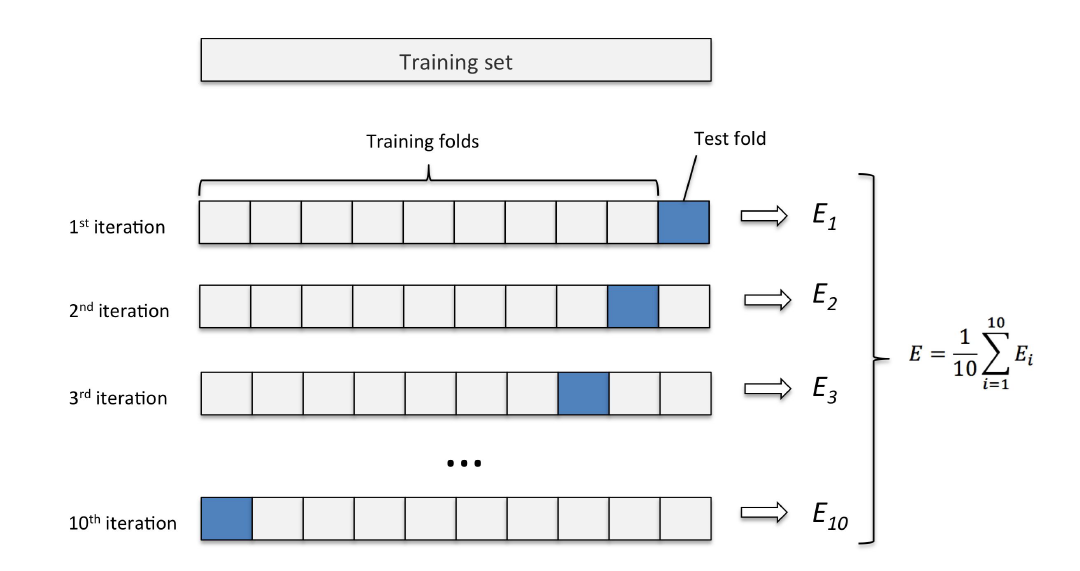

À medida que você aumenta o número de folds, o número de observações em cada fold diminui e a variância dos erros fold-a-fold aumenta.

#8.0 Improve the model

In [74]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [ ]:
# KNN Algorithm tuning (melhorar o modelo inicial)

# hyperparameter (Vamos ajustar os parâmetros do algoritmo)
k_values = np.array([1,5,10,15,20,25]) #default=5
weights = ["uniform","distance"]  #default=’uniform’
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']  #default=’auto’
metric = [1,2]  #default=2

#Quantidade de folds a ser utilizado no Cross-Validation
num_folds = 10

# number of combinations
models = (len(k_values) * len(weights) * len(algorithm) * len(metric))
rounds = models * num_folds

print(f"Number of models: {models}")
print(f"Complexity of evalution: {rounds} rounds")

param_grid = dict(n_neighbors=k_values,
                  weights=weights,
                  algorithm=algorithm,
                  p=metric)

# instantiate a model
model = KNeighborsRegressor()

# Test options and evaluation metric
scoring = 'neg_mean_squared_error'

# Grid Searching with cross-validation
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    scoring=scoring,
                    cv=kfold)

In [ ]:
# train the model
grid_result = grid.fit(train_X_df,train_y)

# Print results
print("Best: %f using %s" % (np.sqrt(-grid_result.best_score_),
                             grid_result.best_params_))

means = np.sqrt(-grid_result.cv_results_['mean_test_score'])
stds = np.sqrt(grid_result.cv_results_['std_test_score'])
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
result = pd.DataFrame(grid_result.cv_results_)
result.head()

In [ ]:
result.shape

In [ ]:
result.sort_values(by="rank_test_score")

Vamos submeter o conjunto de teste ao melhor modelo

In [ ]:
# predict using the best estimator

predict = grid_result.best_estimator_.predict(test_X_df)
rmse = np.sqrt(mean_squared_error(test_y,predict))
print(rmse)

#9.0 Save the model

In [81]:
import pickle
import joblib

In [84]:
# Salva o modelo usando pickle
with open('pipe.pkl', 'wb') as file:
  pickle.dump(grid_result, file)

In [85]:
# Salva o modelo usando joblib
with open('pipe.joblib', 'wb') as file:
  joblib.dump(grid_result, file)

In [ ]:
# Coloca o modelo em produção usando [pickle]
with open('pipe.pkl', 'rb') as file:
  model = pickle.load(file)

predict = model.best_estimator_.predict(test_X_df)
rmse = np.sqrt(mean_squared_error(predict,test_y))
print(rmse)

In [ ]:
# Coloca o modelo em produção usando [joblib]
with open('pipe.joblib', 'rb') as file:
  model = joblib.load(file)

predict = model.best_estimator_.predict(test_X_df)
rmse = np.sqrt(mean_squared_error(predict,test_y))
print(rmse)